# EXPLORATORY DATA ANALYSIS

This is a critical process of performing initial investigations on the cleaned data to discover patterns, spot anomalies and to check assumptions with the help of summary statistics and graphical representations.

# QUESTIONS ABOUT THE DATA

<ul>
	<li>Which neighborhood has the most Airbnb listings? Which one has the least?</li>
    <li>What is the distribution of price?</li>
    <li>What is the distribution of price for each neighborhood?</li>
	<li>What is the distribution of room_type?</li>
	<li>Which room_type gets booked the most which gets booked the least?</li>
    <li>What is the average price for each room_type?</li>
    <li>What is the distribution of price for each room_type?</li>
	<li>What number of bedrooms, bathrooms, beds and accommodates get booked the most?</li>
    <li>What is the distribution of price for bedrooms, bathrooms, beds and accommodates?</li>
    <li>What is the average price of listings with the same amount of bedrooms, bathrooms, beds and accommodates?</li>
	<li>How does review_scores_rating relate to price?</li>
    <li>How does review_scores_rating relate to number_of_bookings?</li>
    <li>What is the distribution of review_scores_rating?</li>
	<li>What is the distribution of minimum nights? Does it affect number of bookings?</li>
    <li>How does bedroom_bath_ratio relate to price?</li>
    <li>How does bedroom_bath_ratio related to the number_of_bookings?</li>
    <li>What is the distribution of bedroom_bath_ratio?</li>
	<li>How is price distributed on the map (by neighborhoods)?</li>
</ul>

I will use statistics and data visualization to explore and answer the questions above.

In [29]:
# Import required libraries
%matplotlib inline
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels
import pymc3
import numpy

# Read in the csv file
df = pd.read_csv('Data/airbnb_clean.csv')
df.head()

,listing_id,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,number_of_reviews,review_scores_rating,number_of_bookings,bedroom_bath_ratio
0,2265,78702,30.27750,-97.71398,Entire home/apt,4,2.0,2.0,2.0,225.0,30,24,93.0,365.0,100.0
1,5245,78702,30.27577,-97.71379,Private room,2,1.0,1.0,2.0,100.0,30,9,91.0,354.0,100.0
2,5456,78702,30.26112,-97.73448,Entire home/apt,3,1.0,1.0,2.0,95.0,2,499,96.0,74.0,100.0
3,5769,78729,30.45596,-97.78370,Private room,2,1.0,1.0,1.0,40.0,1,253,98.0,352.0,100.0
4,6413,78704,30.24829,-97.73726,Entire home/apt,2,1.0,1.0,1.0,99.0,3,100,99.0,365.0,100.0


In [30]:
df['room_type'] = df['room_type'].astype('category')
print(df['room_type'].dtype)
df.info()

category
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11333 entries, 0 to 11332
Data columns (total 15 columns):
listing_id                11333 non-null int64
neighbourhood_cleansed    11333 non-null int64
latitude                  11333 non-null float64
longitude                 11333 non-null float64
room_type                 11333 non-null category
accommodates              11333 non-null int64
bathrooms                 11333 non-null float64
bedrooms                  11333 non-null float64
beds                      11333 non-null float64
price                     11333 non-null float64
minimum_nights            11333 non-null int64
number_of_reviews         11333 non-null int64
review_scores_rating      11333 non-null float64
number_of_bookings        11333 non-null float64
bedroom_bath_ratio        11333 non-null float64
dtypes: category(1), float64(9), int64(5)
memory usage: 1.2 MB


<b>Which neighborhood has the most Airbnb listings? Which one has the least?</b>

Text(0.5, 0, 'Number of Listings')

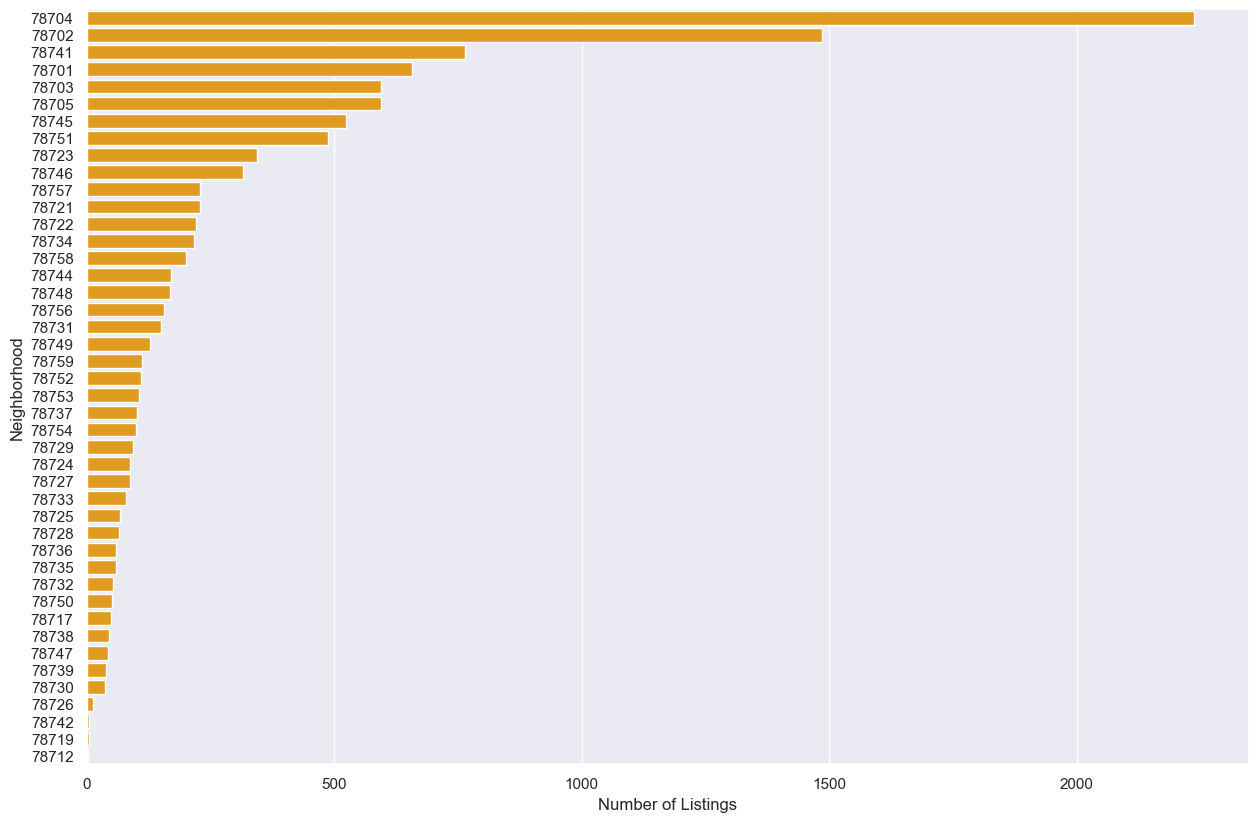

In [31]:
sns.set()
fig=plt.figure(figsize=(15,10), dpi=100)
sns.countplot(y='neighbourhood_cleansed', data=df, color='orange', order=df['neighbourhood_cleansed'].value_counts().index)
plt.ylabel("Neighborhood")
plt.xlabel("Number of Listings")

78704 neighborhood has the most listings and 78712 has the least.

<b>What is the distribution of price?</b>

Text(0.5, 0, 'Price')

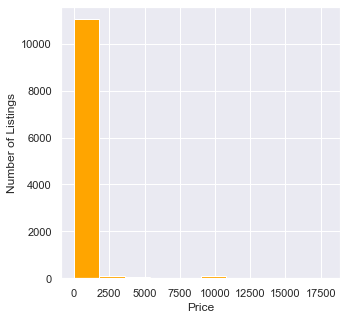

In [32]:
plt.figure(figsize=(5,5))
plt.hist(df['price'], color='orange')
plt.ylabel('Number of Listings')
plt.xlabel('Price')

Based on the graph above, almost all of the listings are priced under $1,500 dollars. I will take a closer look at the data.

Text(0.5, 0, 'Price')

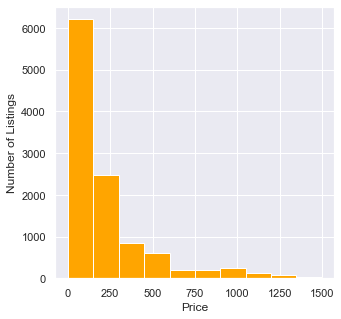

In [33]:
plt.figure(figsize=(5,5))
new_df = df[df['price'] < 1500]
plt.hist(new_df['price'], color='orange')
plt.ylabel('Number of Listings')
plt.xlabel('Price')

It looks like most of the listings fall below $250 a night. 

<b>What is the distribution of price for each neighborhood?</b>

Text(0.5, 0, 'Price')

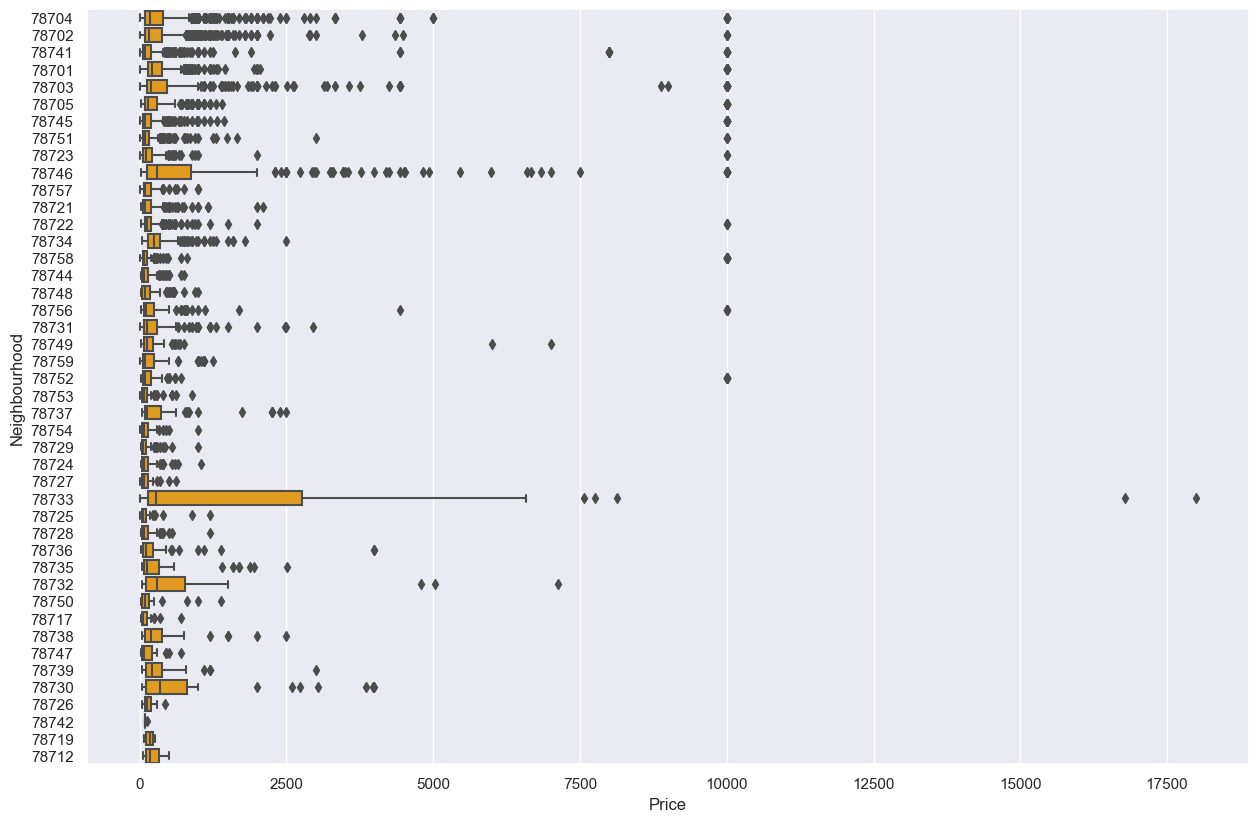

In [34]:
fig=plt.figure(figsize=(15,10), dpi=100)
sns.boxplot(y='neighbourhood_cleansed', x='price', data=df, orient='h', color='orange', order=df['neighbourhood_cleansed'].value_counts().index)
plt.ylabel("Neighbourhood")
plt.xlabel("Price")

It seems the bulk of listings in neighborhood 78733 are priced higher than the rest.

<b>What is the distribution of room_type?</b>

Text(0.5, 0, 'Number of Listings')

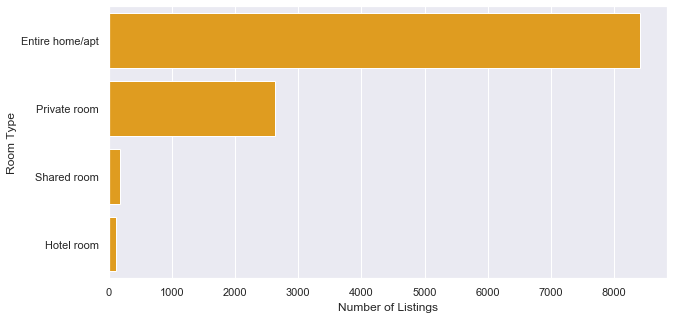

In [35]:
fig=plt.figure(figsize=(10,5))
sns.countplot(y='room_type', data=df, color='orange', order=df['room_type'].value_counts().index)
plt.ylabel("Room Type")
plt.xlabel("Number of Listings")

The majority of listings are of the entire home/apt room_type. Hotel room has the least amount. 

<b>Which room_type gets booked the most which gets booked the least?</b>

In [38]:
# Calculate the percentage of bookings in the past year, for each listing, and put it into a new column
df['percentage_booked'] = (df['number_of_bookings'] / 365) * 100

# Create a groupby variable that groups percentage_booked values by room_type
groupby_room_type = df['percentage_booked'].groupby(df['room_type'])

# Get the mean of percentage_booked grouped by room_type
room_type_mean = groupby_room_type.mean().sort_values(ascending=True)

# Inspect the calculations
room_type_mean

room_type
Hotel room         32.912140
Shared room        60.544918
Entire home/apt    62.093049
Private room       71.433978
Name: percentage_booked, dtype: float64

(0, 100)

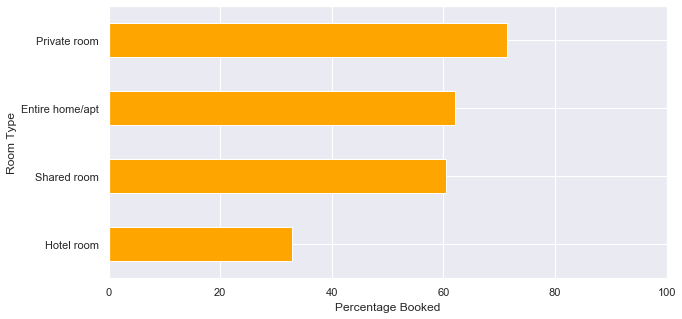

In [39]:
plt.figure(figsize=(10,5))
room_type_mean.plot.barh(color='orange')
plt.xlabel('Percentage Booked')
plt.ylabel('Room Type')
plt.xlim(0, 100)

It looks like private room gets booked the most, around 70 percent. Entire home/apt and shared room are not far behind, around 60 percent. Hotel room gets booked the least, around 30 percent.

<b>What is the average price for each room_type?</b>

In [40]:
# Create a groupby variable that groups price values by room_type
groupby_room_type = df['price'].groupby(df['room_type'])

# Get the mean of prices grouped by room_type
price_mean = groupby_room_type.mean().sort_values(ascending=True)

# Inspect the calculations
price_mean

room_type
Shared room         72.044199
Private room       107.075723
Entire home/apt    484.886299
Hotel room         506.905172
Name: price, dtype: float64

Text(0, 0.5, 'Room Type')

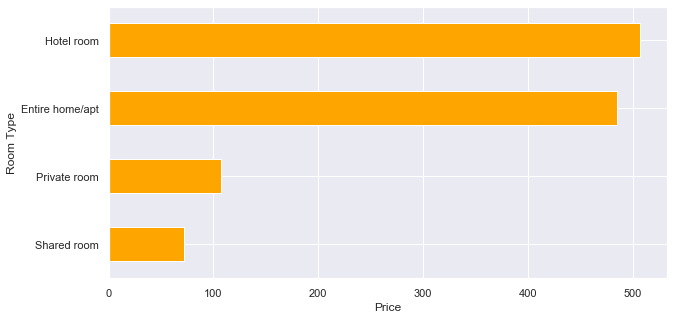

In [41]:
plt.figure(figsize=(10,5))
price_mean.plot.barh(color='orange')
plt.xlabel('Price')
plt.ylabel('Room Type')

Hotel and entire home/apt have the highest average prices. The average price of hotel and entire home/apt are 3 to 4 times larger than the average price of private room. The average price of a shared room is about 25% cheaper than private room.

<b>What is the distribution of price for each room_type?</b>

Text(0.5, 0, 'Price')

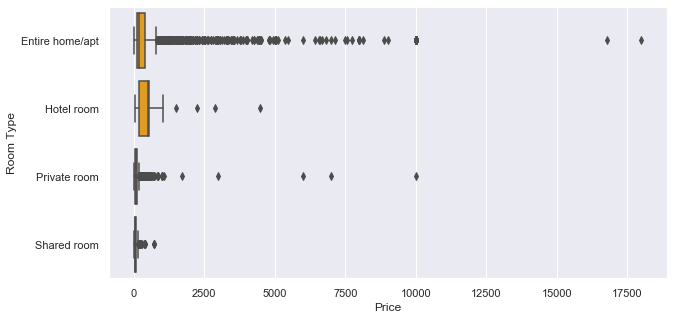

In [42]:
fig=plt.figure(figsize=(10,5))
sns.boxplot(x='price', y='room_type', data=df, color='orange')
plt.ylabel("Room Type")
plt.xlabel("Price")

<b>What number of bedrooms, bathrooms, beds and accommodates get booked the most?</b>

In [43]:
# Create a groupby variable that groups percentage_booked values by bedrooms 
groupby_bedrooms = df['percentage_booked'].groupby(df['bedrooms'])

# Get the mean of percentage_booked grouped by bedrooms
bedrooms_mean = groupby_bedrooms.mean().sort_values(ascending=True)

# Inspect the calculations
bedrooms_mean

bedrooms
9.0      8.383562
7.0     17.093933
12.0    18.630137
10.0    19.921722
13.0    20.821918
14.0    27.397260
8.0     27.968037
6.0     30.565265
15.0    32.876712
5.0     33.882043
23.0    37.260274
4.0     47.681380
3.0     61.459187
2.0     63.793538
0.0     66.970473
1.0     68.736682
Name: percentage_booked, dtype: float64

(0, 100)

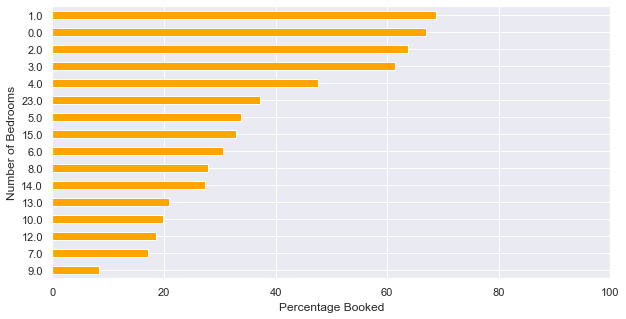

In [44]:
plt.figure(figsize=(10,5))
bedrooms_mean.plot.barh(color='orange')
plt.xlabel('Percentage Booked')
plt.ylabel('Number of Bedrooms')
plt.xlim(0, 100)

Listings that have 0 to 3 bedrooms have a significantly higher booking rate than all of the other bedrooms.

In [45]:
# Create a groupby variable that groups percentage_booked values by bathrooms 
groupby_bathrooms = df['percentage_booked'].groupby(df['bathrooms'])

# Get the mean of percentage_booked grouped by bathrooms
bathrooms_mean = groupby_bathrooms.mean().sort_values(ascending=True)

# Inspect the calculations
bathrooms_mean

bathrooms
7.00     12.328767
3.25     13.972603
6.50     16.310502
9.00     20.821918
6.00     24.720759
5.00     28.195354
5.50     30.308219
3.75     31.068493
4.00     31.247392
11.00    32.876712
5.75     35.342466
17.00    37.260274
7.50     38.812785
8.00     42.237443
0.00     46.893504
4.50     48.552160
3.00     50.081515
3.50     51.048680
2.00     59.172605
2.50     61.076005
1.50     66.385084
1.00     68.417090
0.50     88.809273
Name: percentage_booked, dtype: float64

(0, 100)

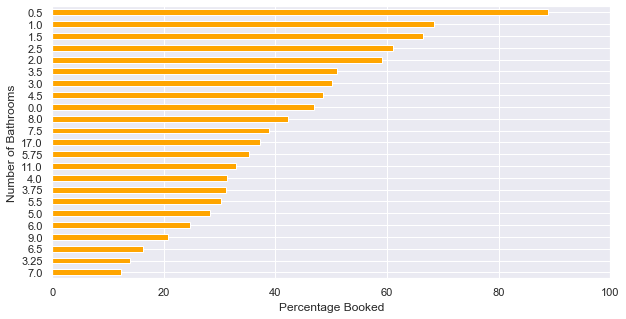

In [46]:
plt.figure(figsize=(10,5))
bathrooms_mean.plot.barh(color='orange')
plt.xlabel('Percentage Booked')
plt.ylabel('Number of Bathrooms')
plt.xlim(0, 100)

Listings that have 0.5 bathrooms get booked the most. 

In [47]:
# Create a groupby variable that groups percentage_booked values by beds
groupby_beds = df['percentage_booked'].groupby(df['beds'])

# Get the mean of percentage_booked grouped by beds
beds_mean = groupby_beds.mean().sort_values(ascending=True)

# Inspect the calculations
beds_mean

beds
23.0      4.109589
22.0      6.301370
33.0      7.671233
24.0      8.630137
25.0      8.767123
17.0      8.767123
18.0      9.908676
30.0     10.136986
11.0     11.413699
28.0     12.876712
16.0     14.246575
12.0     14.559687
15.0     15.232877
26.0     15.273973
14.0     16.733404
19.0     22.054795
13.0     24.919595
132.0    27.397260
9.0      31.809661
39.0     32.876712
61.0     37.260274
10.0     37.922991
8.0      43.149301
7.0      43.478568
6.0      51.053174
5.0      52.047149
4.0      59.392006
3.0      60.529744
0.0      60.811771
36.0     61.095890
2.0      66.221364
1.0      70.899028
Name: percentage_booked, dtype: float64

(0, 100)

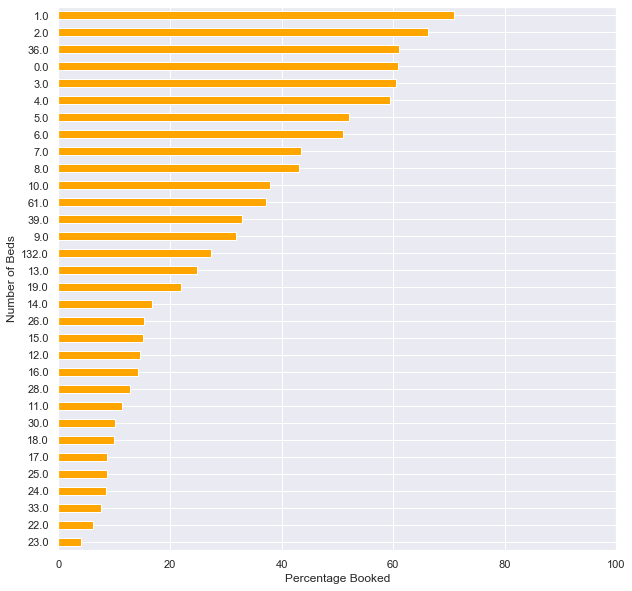

In [48]:
plt.figure(figsize=(10,10))
beds_mean.plot.barh(color='orange')
plt.xlabel('Percentage Booked')
plt.ylabel('Number of Beds')
plt.xlim(0, 100)

Listings that have 1 or 2 beds get booked the most.

In [49]:
# Create a groupby variable that groups percentage_booked values by accommodates
groupby_accommodates = df['percentage_booked'].groupby(df['accommodates'])

# Get the mean of percentage_booked grouped by beds
accommodates_mean = groupby_accommodates.mean().sort_values(ascending=True)

# Inspect the calculations
accommodates_mean

accommodates
25     3.835616
18     7.945205
30     8.630137
19    10.958904
24    11.232877
21    12.534247
20    13.947696
32    16.164384
28    17.671233
17    17.808219
16    22.411650
15    31.580611
14    33.526886
12    39.605294
10    43.742617
13    48.513445
11    50.182648
9     57.704718
8     58.463811
6     62.182620
4     63.742941
1     64.584848
7     67.894592
2     71.096592
5     71.173793
3     72.409768
Name: percentage_booked, dtype: float64

(0, 100)

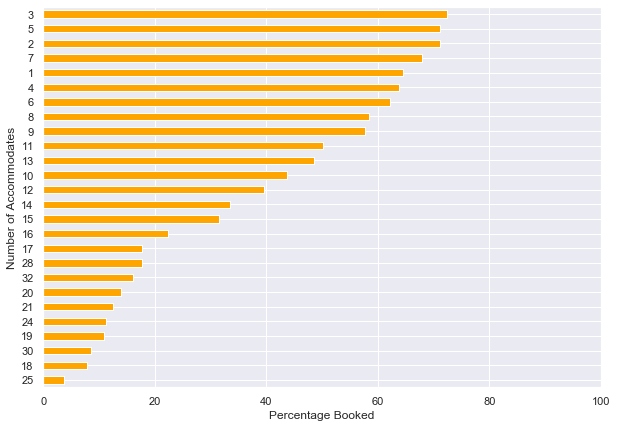

In [50]:
plt.figure(figsize=(10,7))
accommodates_mean.plot.barh(color='orange')
plt.xlabel('Percentage Booked')
plt.ylabel('Number of Accommodates')
plt.xlim(0, 100)

Listings that can accommodate 3 people gets booked the most. Those that can accommodate 5, 2 or 7 people are not very far behind.

<b>What is the distribution of price for bedrooms, bathrooms, beds and accommodates?</b>

Text(0.5, 0, 'Price')

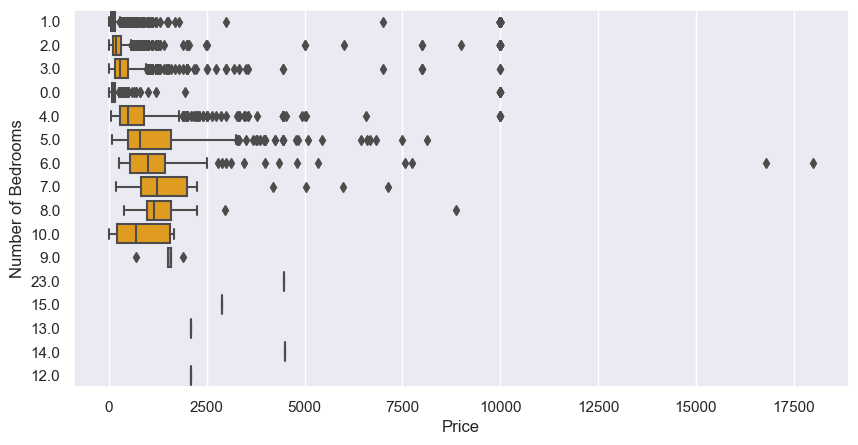

In [51]:
fig=plt.figure(figsize=(10,5), dpi=100)
sns.boxplot(y='bedrooms', x='price', data=df, orient='h', color='orange', order=df['bedrooms'].value_counts().index)
plt.ylabel("Number of Bedrooms")
plt.xlabel("Price")

Text(0.5, 0, 'Price')

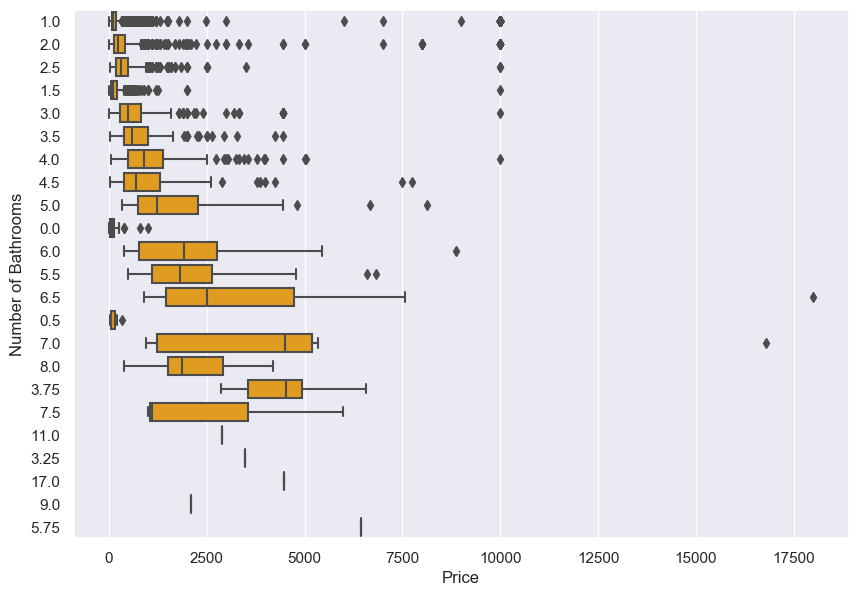

In [52]:
fig=plt.figure(figsize=(10,7), dpi=100)
sns.boxplot(y='bathrooms', x='price', data=df, orient='h', color='orange', order=df['bathrooms'].value_counts().index)
plt.ylabel("Number of Bathrooms")
plt.xlabel("Price")

Text(0.5, 0, 'Price')

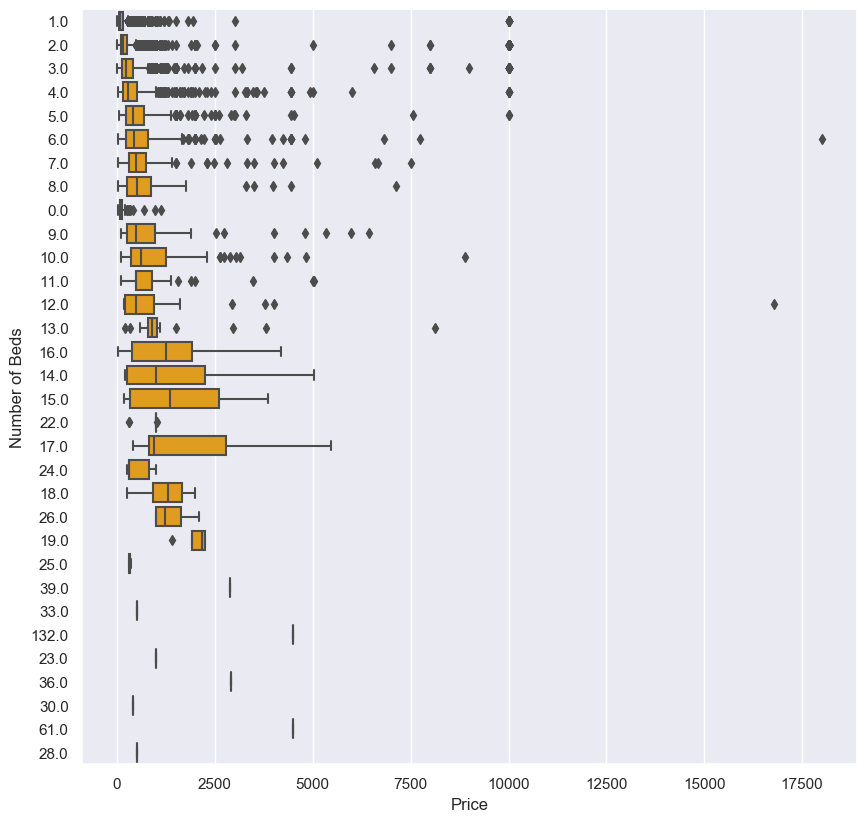

In [53]:
fig=plt.figure(figsize=(10,10), dpi=100)
sns.boxplot(y='beds', x='price', data=df, orient='h', color='orange', order=df['beds'].value_counts().index)
plt.ylabel("Number of Beds")
plt.xlabel("Price")

Text(0.5, 0, 'Price')

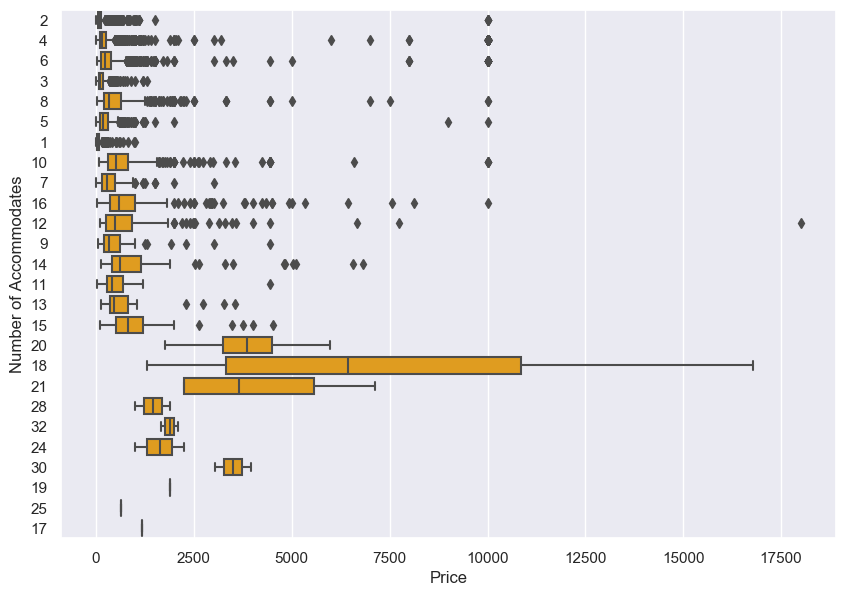

In [54]:
fig=plt.figure(figsize=(10,7), dpi=100)
sns.boxplot(y='accommodates', x='price', data=df, orient='h', color='orange', order=df['accommodates'].value_counts().index)
plt.ylabel("Number of Accommodates")
plt.xlabel("Price")

<b>What is the average price of listings with the same amount of bedrooms, bathrooms, beds and accommodates?</b>

In [55]:
# Create a groupby variable that groups price values by bedrooms 
groupby_bedrooms = df['price'].groupby(df['bedrooms'])

# Get the mean of price grouped by bedrooms
bedrooms_mean = groupby_bedrooms.mean()

# Inspect the calculations
bedrooms_mean

bedrooms
0.0      233.593438
1.0      290.605499
2.0      347.426009
3.0      421.109536
4.0      805.611852
5.0     1383.393305
6.0     1756.689655
7.0     1789.535714
8.0     1910.333333
9.0     1458.000000
10.0     844.285714
12.0    2100.000000
13.0    2100.000000
14.0    4500.000000
15.0    2893.000000
23.0    4485.000000
Name: price, dtype: float64

Text(0, 0.5, 'Number of Bedrooms')

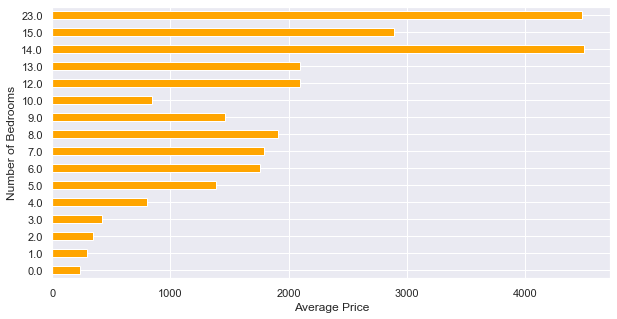

In [56]:
plt.figure(figsize=(10,5))
bedrooms_mean.plot.barh(color='orange')
plt.xlabel('Average Price')
plt.ylabel('Number of Bedrooms')

In [57]:
# Create a groupby variable that groups price values by bathrooms 
groupby_bathrooms = df['price'].groupby(df['bathrooms'])

# Get the mean of price grouped by bathrooms
bathrooms_mean = groupby_bathrooms.mean()

# Inspect the calculations
bathrooms_mean

bathrooms
0.00      146.354839
0.50      103.153846
1.00      298.581701
1.50      179.490278
2.00      420.213539
2.50      427.481183
3.00      718.002469
3.25     3470.000000
3.50      839.288136
3.75     4490.400000
4.00     1196.158940
4.50     1198.523077
5.00     1845.173913
5.50     2271.125000
5.75     6437.000000
6.00     2259.038462
6.50     4063.066667
7.00     5007.571429
7.50     2699.000000
8.00     2163.000000
9.00     2100.000000
11.00    2893.000000
17.00    4485.000000
Name: price, dtype: float64

Text(0, 0.5, 'Number of Bathrooms')

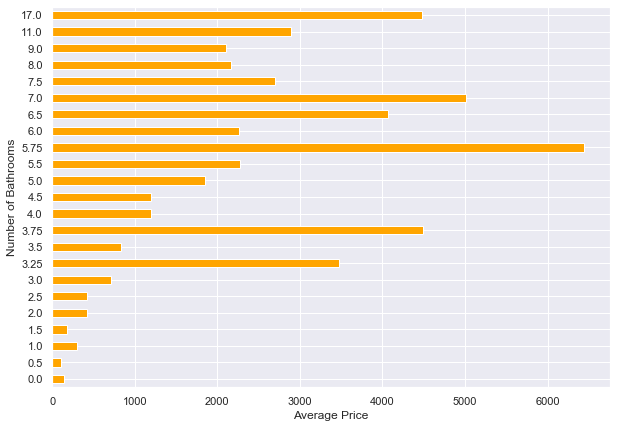

In [58]:
plt.figure(figsize=(10,7))
bathrooms_mean.plot.barh(color='orange')
plt.xlabel('Average Price')
plt.ylabel('Number of Bathrooms')

In [59]:
# Create a groupby variable that groups price values by beds 
groupby_beds = df['price'].groupby(df['beds'])

# Get the mean of price grouped by beds
beds_mean = groupby_beds.mean()

# Inspect the calculations
beds_mean

beds
0.0       140.604938
1.0       141.985475
2.0       497.025467
3.0       462.507576
4.0       537.129514
5.0       625.825581
6.0       809.964158
7.0       804.367742
8.0       770.383838
9.0       915.736842
10.0     1125.500000
11.0      865.420000
12.0     1200.285714
13.0     1373.260870
14.0     1468.461538
15.0     1623.800000
16.0     1357.062500
17.0     2002.142857
18.0     1232.166667
19.0     1998.750000
22.0      838.333333
23.0      989.000000
24.0      520.666667
25.0      324.000000
26.0     1390.750000
28.0      499.000000
30.0      399.000000
33.0      499.000000
36.0     2899.000000
39.0     2893.000000
61.0     4485.000000
132.0    4500.000000
Name: price, dtype: float64

Text(0, 0.5, 'Number of Beds')

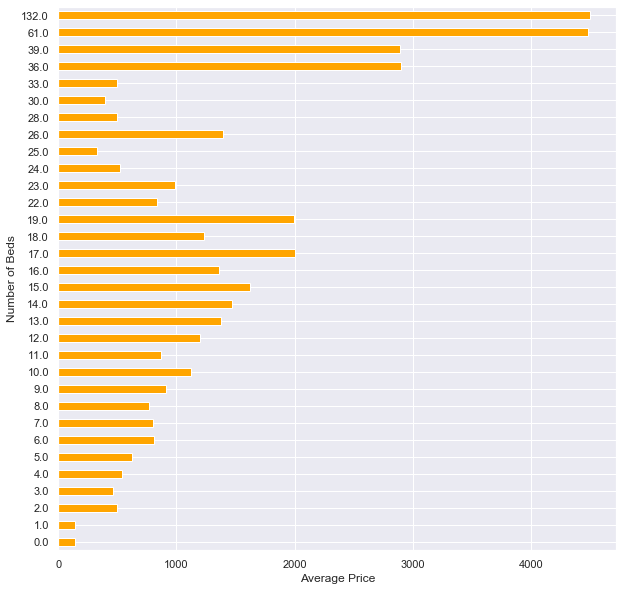

In [60]:
plt.figure(figsize=(10,10))
beds_mean.plot.barh(color='orange')
plt.xlabel('Average Price')
plt.ylabel('Number of Beds')

In [61]:
# Create a groupby variable that groups price values by accommodates 
groupby_accommodates = df['price'].groupby(df['accommodates'])

# Get the mean of price grouped by accommodates
accommodates_mean = groupby_accommodates.mean()

# Inspect the calculations
accommodates_mean

accommodates
1       76.744898
2      127.481102
3      143.165217
4      571.428229
5      279.977636
6      439.650774
7      355.377510
8      560.805022
9      517.888889
10     800.245413
11     578.214286
12     925.564972
13     859.074074
14    1217.880597
15    1312.423077
16    1035.911765
17    1170.000000
18    7740.750000
19    1900.000000
20    3900.909091
21    4165.500000
24    1622.500000
25     633.000000
28    1450.500000
30    3505.000000
32    1882.500000
Name: price, dtype: float64

Text(0, 0.5, 'Number of Accommodates')

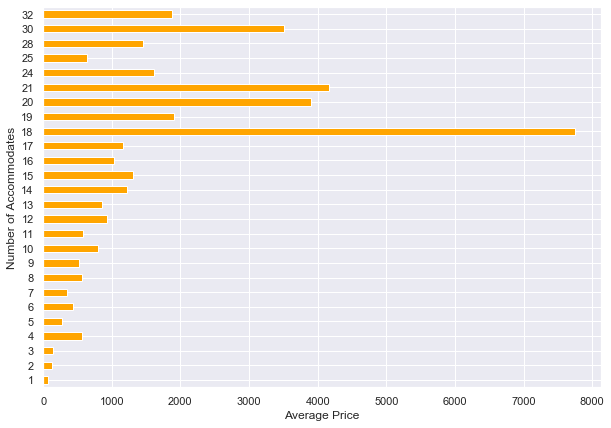

In [62]:
plt.figure(figsize=(10,7))
accommodates_mean.plot.barh(color='orange')
plt.xlabel('Average Price')
plt.ylabel('Number of Accommodates')

<b>How does review_scores_rating relate to price?</b>

(0, 100)

<Figure size 28800x28800 with 0 Axes>

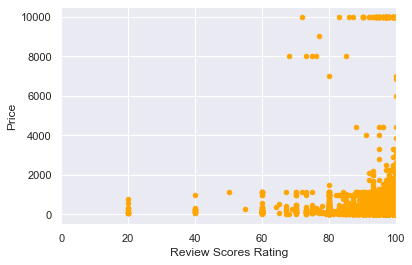

In [63]:
# Subset only listings that have a review_scores_rating of more than -1 (the flagged value)
new_df = df[df['review_scores_rating'] > -1]
plt.figure(figsize=(400,400))
new_df.plot.scatter('review_scores_rating','price', color='orange')
plt.xlabel('Review Scores Rating')
plt.ylabel('Price')
plt.xlim(0,100)

reviews_scores_rating doesn't seem to have too much of an affect on the price, although there are several higher prices in the 10,000 range that tend to have higher ratings.

<b>How does review_scores_rating relate to number_of_bookings?</b>

(0, 100)

<Figure size 28800x28800 with 0 Axes>

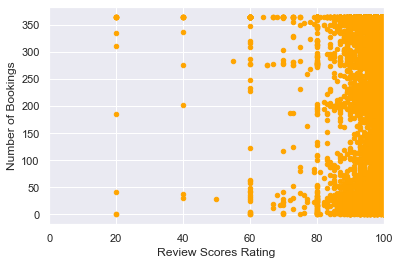

In [64]:
plt.figure(figsize=(400,400))
new_df.plot.scatter('review_scores_rating','number_of_bookings', color='orange')
plt.xlabel('Review Scores Rating')
plt.ylabel('Number of Bookings')
plt.xlim(0,100)

reviews_scores_rating doesn't seem to have an affect on the number_of_bookings at all. It looks like there are many listings with a high review score and nearly zero bookings. Most of the bookings are above 80%. 

<b>What is the distribution of review_scores_rating?</b>

Text(0.5, 0, 'Review Scores Rating')

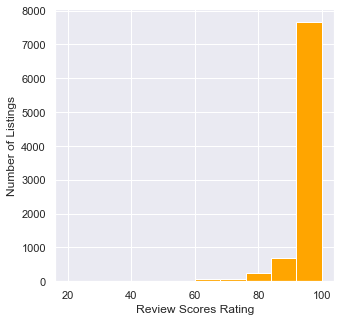

In [65]:
plt.figure(figsize=(5,5))
plt.hist(new_df['review_scores_rating'], color='orange')
plt.ylabel('Number of Listings')
plt.xlabel('Review Scores Rating')

Most of the review_scores_rating is over 80 or around 0. 

<b>What's the distribution of minimum nights?</b>

Text(0, 0.5, 'Minimum Nights to Book')

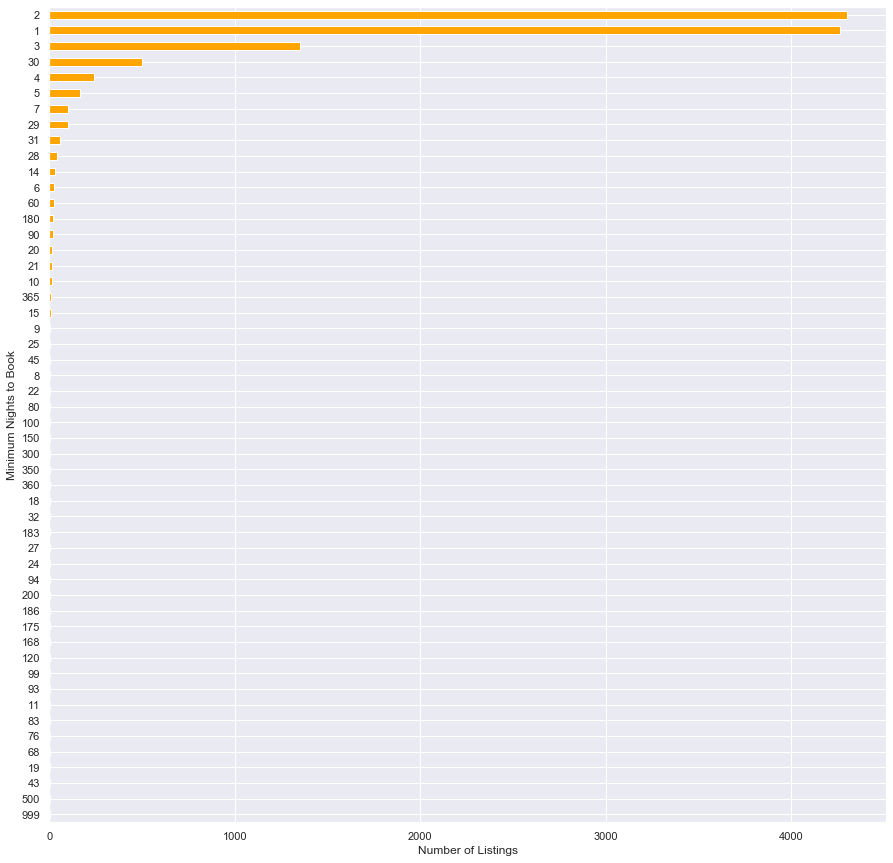

In [66]:
plt.figure(figsize=(15,15))
df.groupby(['minimum_nights']).size().sort_values().plot.barh(color='orange')
plt.xlabel('Number of Listings')
plt.ylabel('Minimum Nights to Book')

Most of the listings require a booking of 1 or 2 minimum nights.

<b>Does minimum_nights affect number_of_bookings?</b>

Text(0, 0.5, 'Number of Bookings')

<Figure size 28800x28800 with 0 Axes>

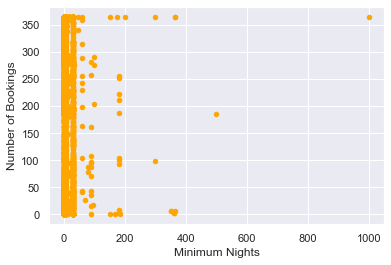

In [67]:
plt.figure(figsize=(400,400))
new_df.plot.scatter('minimum_nights','number_of_bookings', color='orange')
plt.xlabel('Minimum Nights')
plt.ylabel('Number of Bookings')

It does not seem that minimum_nights affects the number_of_bookings. There are many listings that have low booking percentage and low minimum_nights. Most of the listings seem to require less than 50 minimum nights.

<b>How does bedroom_bath_ratio relate to price?</b>

Text(0, 0.5, 'Price')

<Figure size 28800x28800 with 0 Axes>

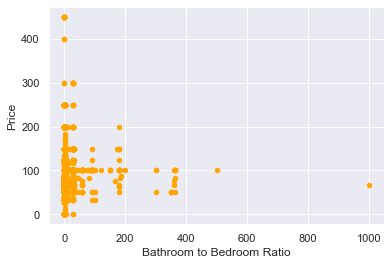

In [68]:
plt.figure(figsize=(400,400))
new_df = df[df['bedroom_bath_ratio'] > -1]
new_df.plot.scatter('minimum_nights','bedroom_bath_ratio', color='orange')
plt.xlabel('Bathroom to Bedroom Ratio')
plt.ylabel('Price')

The bathroom to bedroom ratio doesn't seem to have a direct relation with price.

<b>How does bedroom_bath_ratio relate to the number_of_bookings?</b>

Text(0, 0.5, 'Number of Bookings')

<Figure size 28800x28800 with 0 Axes>

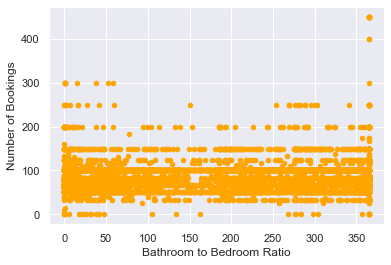

In [69]:
plt.figure(figsize=(400,400))
new_df = df[df['bedroom_bath_ratio'] > -1]
new_df.plot.scatter('number_of_bookings','bedroom_bath_ratio', color='orange')
plt.xlabel('Bathroom to Bedroom Ratio')
plt.ylabel('Number of Bookings')

There seems to be no direct relation between the bathroom to bedroom ratio and price.

<b>What is the distribution of bedroom_bath_ratio?</b>

Text(0.5, 0, 'Bathroom to Bedroom Ratio')

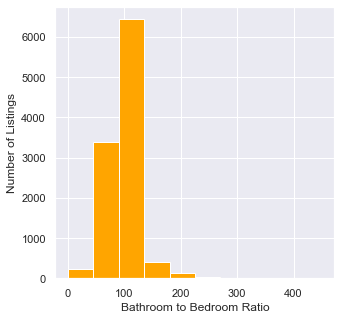

In [70]:
plt.figure(figsize=(5,5))
plt.hist(new_df['bedroom_bath_ratio'], color='orange')
plt.ylabel('Number of Listings')
plt.xlabel('Bathroom to Bedroom Ratio')

It looks like most listings fall around the 1:1 for bathroom to bedroom ratio.

<b>How is price distributed on the map (by neighborhoods)?</b>

In [71]:
# Get the filepath and load in a shapefile
map_df = gpd.read_file('Data/neighbourhoods.geojson')

# Change the neighbourhood data type to int to match with the data type in the second data frame
map_df['neighbourhood'] = map_df['neighbourhood'].astype(int)

# Set the neighbourhood column as the index
map_df = map_df.set_index('neighbourhood')

# Check data type so we can see that this is a GEOdataframe, not a normal dataframe
map_df.head()

,neighbourhood_group,geometry
neighbourhood,,
78739,None,"MULTIPOLYGON (((-97.89002 30.20941, -97.88929 ..."
78754,None,"MULTIPOLYGON (((-97.63658 30.40266, -97.63754 ..."
78732,None,"MULTIPOLYGON (((-97.87303 30.43806, -97.87335 ..."
78737,None,"MULTIPOLYGON (((-98.01876 30.24167, -98.01617 ..."
78756,None,"MULTIPOLYGON (((-97.72792 30.32906, -97.72760 ..."


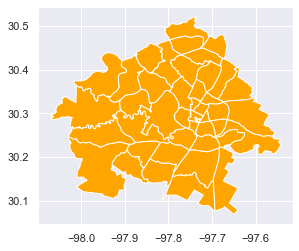

In [72]:
# Inspect the map function is working
map_df.plot(color='orange')

In [73]:
# Get a subset of the dataframe, columns neighbourhood and price
subset_df = df[['neighbourhood_cleansed', 'price']]

# Rename column for joining dataframes later
subset_df.rename(columns = {'neighbourhood_cleansed':'neighbourhood'}, inplace = True)

# Inspect the head of the subset dataframe
subset_df.head()

/Users/ammadatuy/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,neighbourhood,price
0,78702,225.0
1,78702,100.0
2,78702,95.0
3,78729,40.0
4,78704,99.0


In [74]:
# Get mean for the price
data_for_map = subset_df.groupby('neighbourhood')['price'].mean().to_frame()
data_for_map

# Merge the two dataframes
merged = map_df.join(data_for_map, on='neighbourhood')

# Inspect the merged dataframe
merged.head()

,neighbourhood_group,geometry,price
neighbourhood,,,
78739,None,"MULTIPOLYGON (((-97.89002 30.20941, -97.88929 ...",391.657895
78754,None,"MULTIPOLYGON (((-97.63658 30.40266, -97.63754 ...",121.303030
78732,None,"MULTIPOLYGON (((-97.87303 30.43806, -97.87335 ...",725.886792
78737,None,"MULTIPOLYGON (((-98.01876 30.24167, -98.01617 ...",335.990196
78756,None,"MULTIPOLYGON (((-97.72792 30.32906, -97.72760 ...",541.794872


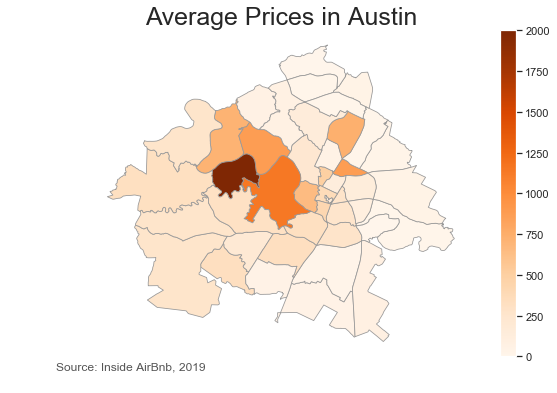

In [75]:
# Set the range for the choropleth
vmin, vmax = 0, 2000

# Create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))

# Remove axes
ax.axis('off')

# Add a title
ax.set_title('Average Prices in Austin', fontdict={'fontsize': '25', 'fontweight' : '3'})

# Create an annotation for the data source
ax.annotate('Source: Inside AirBnb, 2019', xy=(0.1, .08), xycoords='figure fraction', 
            horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Oranges', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# Add the colorbar to the figure
cbar = fig.colorbar(sm)

# Create map and display
plot = merged.plot(column='price', cmap='Oranges', linewidth=0.8, ax=ax, edgecolor='0.6')
plot